## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn4.ipynb의 코드에서 좀 더 dqn3.ipynb와 섞은 버전

In [1]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [2]:
Transition = collections.namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'terminated'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = collections.deque([], maxlen=capacity)

    def append(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
env = gymnasium.make('CartPole-v1')
hidden_size = 128
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, env.action_space.n)
)
target_q = copy.deepcopy(q)

In [4]:
lr = 1e-4
discount = 0.99
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(q.parameters(), lr=lr, amsgrad=True)
replay_buffer = ReplayMemory(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [5]:
steps = []
action_count = 0
device = 'cpu'
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    for step in itertools.count():
        eps = eps_end + (eps_start - eps_end) * math.exp(-action_count / eps_decay)
        action_count += 1
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            action = q(torch.tensor(state)).argmax().cpu().detach().item()
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Store the transition in memory
        replay_buffer.append(state, action, reward, next_state, terminated)
     
        if len(replay_buffer) >= batch_size:
            transitions = replay_buffer.sample(batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = ~torch.tensor(batch.terminated)
            non_final_next_states = torch.tensor(batch.next_state)[non_final_mask] 
            state_batch = torch.tensor(batch.state)
            action_batch = torch.tensor(batch.action)
            reward_batch = torch.tensor(batch.reward)
            state_action_values = q(state_batch).gather(1, action_batch.unsqueeze(1))
            next_state_values = torch.zeros(batch_size, device='cpu')
            with torch.no_grad():
                next_state_values[non_final_mask] = target_q(non_final_next_states).max(1)[0]
            expected_state_action_values = (next_state_values * discount) + reward_batch
            criterion = torch.nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(q.parameters(), 100)
            optimizer.step()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict() 
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    steps.append(step)

    if (i + 1) % 100 == 0:
        print(np.mean(steps[-100:]))

  1%|          | 4/600 [00:00<00:14, 39.93it/s]

/tmp/ipykernel_7787/2151110325.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  non_final_next_states = torch.tensor(batch.next_state)[non_final_mask]
 17%|█▋        | 103/600 [00:05<00:24, 19.97it/s]

12.26


 33%|███▎      | 200/600 [00:27<04:31,  1.47it/s]

48.03


 50%|█████     | 300/600 [01:24<02:45,  1.81it/s]

130.55


 52%|█████▏    | 310/600 [01:30<03:02,  1.59it/s]

 52%|█████▏    | 311/600 [01:31<03:18,  1.46it/s]

In [ ]:
len(replay_buffer)

10000

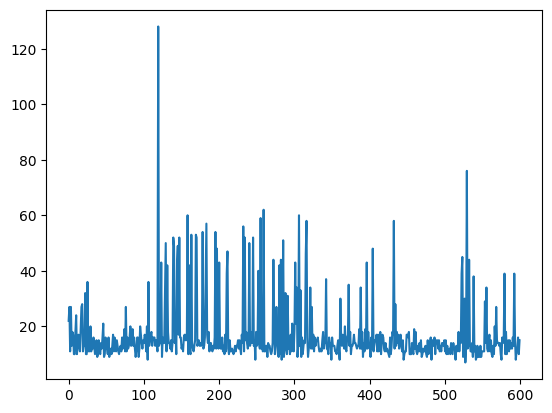

In [ ]:
import matplotlib.pyplot as plt
plt.plot(steps)

In [ ]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[13.0, 16.0, 17.0, 12.0, 13.0, 13.0, 15.0, 13.0, 15.0, 13.0]

In [ ]:
env.close()

In [ ]:
env = gymnasium.make('CartPole-v1')